In [9]:
# COMP30770 - Programming for Big Data

# Team Members: Agampreet Singh Sihota (22204258), Kushagra Mittal (22206254)

import pandas as pd
import time
import platform

# For Spark
!pip install -q pyspark
from pyspark import SparkContext, SparkConf
from io import StringIO
import csv


In [10]:
# Load dataset
start = time.time()
df = pd.read_csv("tracks.csv")
load_time = time.time() - start

print("Dataset Shape:", df.shape)
print("Load Time: {:.2f} sec".format(load_time))
print("Python Version:", platform.python_version())
print("Platform Info:", platform.platform())
print("Columns:", df.columns.tolist())

# Preprocessing
df['year'] = df['release_date'].str[:4]
df = df[df['year'].str.isnumeric()]
df['year'] = df['year'].astype(int)
df['decade'] = (df['year'] // 10) * 10


Dataset Shape: (557221, 20)
Load Time: 12.20 sec
Python Version: 3.11.11
Platform Info: Linux-6.1.85+-x86_64-with-glibc2.35
Columns: ['id', 'name', 'popularity', 'duration_ms', 'explicit', 'artists', 'id_artists', 'release_date', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']


In [11]:
# Step 1 – Yearly Trends
start1 = time.time()
yearly_trends = df.groupby('year')[['tempo', 'energy', 'danceability', 'popularity']].mean()
t1 = time.time() - start1

# Step 2 – Feature Evolution by Decade
start2 = time.time()
feature_trends_decade = df.groupby('decade')[['tempo', 'energy', 'danceability']].mean()
t2 = time.time() - start2

# Step 3 – Top Artists by Decade
start3 = time.time()
top_artists = df.groupby(['decade', 'artists'])['popularity'].mean().reset_index()
top_per_decade = top_artists.sort_values(['decade', 'popularity'], ascending=[True, False]).groupby('decade').head(3)
t3 = time.time() - start3

# Step 4 – Feature Correlation
start4 = time.time()
corr_matrix = df[['tempo', 'energy', 'danceability', 'popularity']].corr()
t4 = time.time() - start4

# Print Results
print("\nYearly Trends:\n", yearly_trends.head())
print("\nFeature Evolution by Decade:\n", feature_trends_decade)
print("\nTop Artists by Decade:\n", top_per_decade)
print("\nCorrelation Matrix:\n", corr_matrix)

# Total Pandas Execution Time
traditional_total = t1 + t2 + t3 + t4
print(f"\nTotal Traditional (Pandas) Execution Time: {traditional_total:.2f} seconds")



Yearly Trends:
            tempo    energy  danceability  popularity
year                                                
1900  141.999000  0.791000      0.659000   19.000000
1922  109.120405  0.324054      0.533320    0.054422
1923  109.552648  0.266977      0.637332    1.575342
1924  119.457894  0.356725      0.593344    0.612954
1925  113.901050  0.263749      0.617391    1.414175

Feature Evolution by Decade:
              tempo    energy  danceability
decade                                    
1900    141.999000  0.791000      0.659000
1920    113.092819  0.281286      0.604308
1930    112.760715  0.307100      0.549660
1940    107.030772  0.267795      0.475666
1950    110.618556  0.297926      0.482154
1960    114.174990  0.406163      0.497303
1970    117.516618  0.504652      0.523086
1980    118.929952  0.551716      0.563307
1990    119.673345  0.575427      0.573787
2000    121.428116  0.650522      0.592356
2010    121.979261  0.656463      0.610374
2020    121.857590  0.

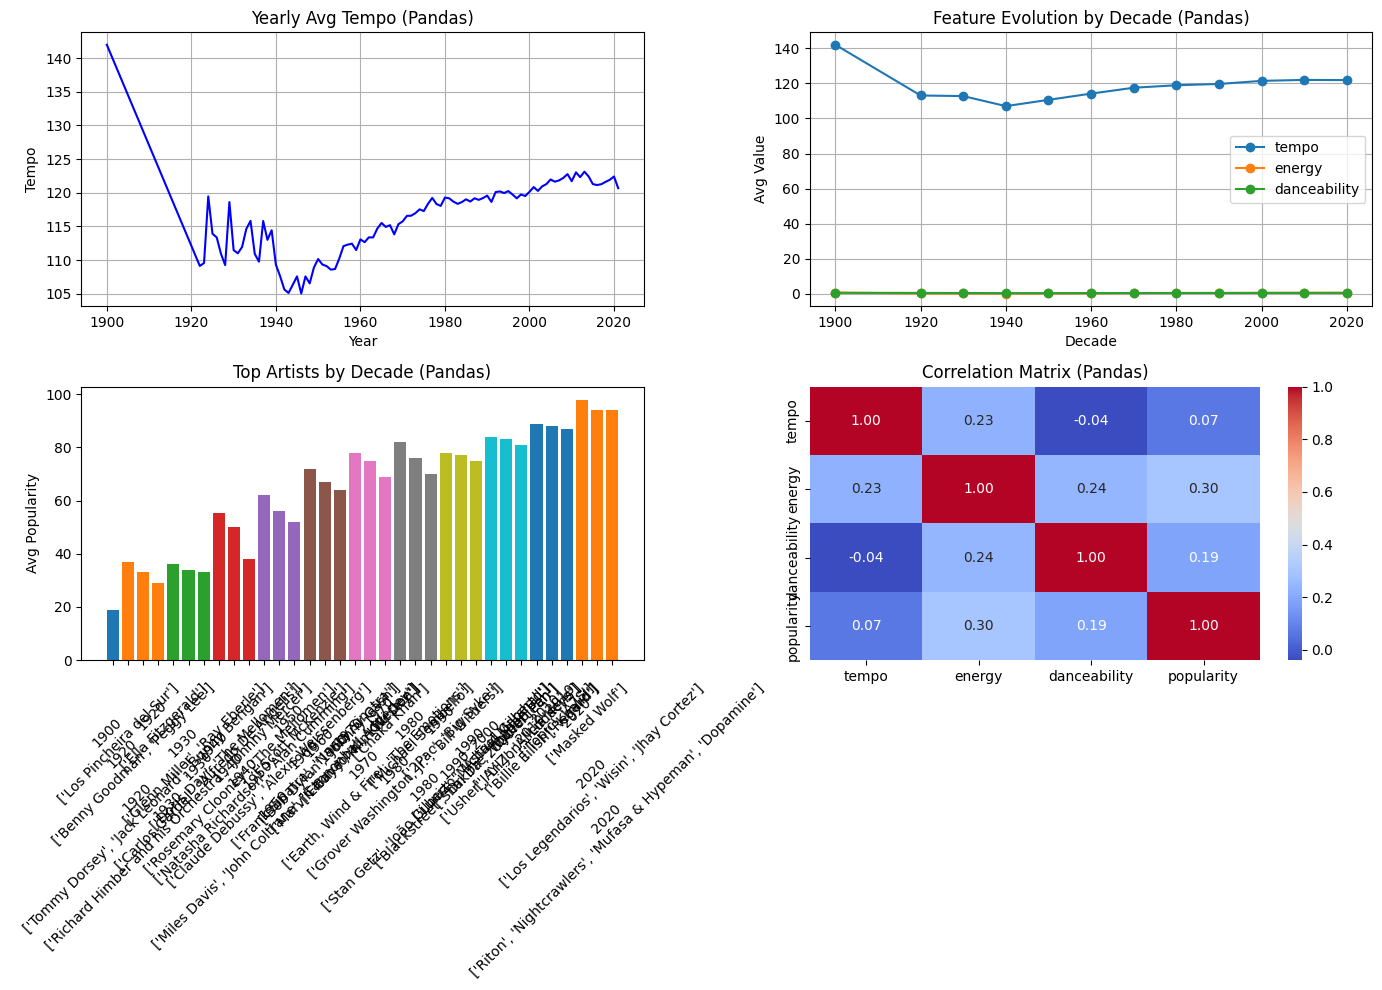

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Step 1: Yearly Tempo Trend
axs[0, 0].plot(yearly_trends.index, yearly_trends['tempo'], color='blue')
axs[0, 0].set_title('Yearly Avg Tempo (Pandas)')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Tempo')
axs[0, 0].grid(True)

# Step 2: Feature Evolution by Decade
feature_trends_decade.plot(ax=axs[0, 1], marker='o')
axs[0, 1].set_title('Feature Evolution by Decade (Pandas)')
axs[0, 1].set_xlabel('Decade')
axs[0, 1].set_ylabel('Avg Value')
axs[0, 1].grid(True)

# Step 3: Top Artists by Decade
for decade in top_per_decade['decade'].unique():
    subset = top_per_decade[top_per_decade['decade'] == decade]
    axs[1, 0].bar([f"{decade}\n{a}" for a in subset['artists']], subset['popularity'])
axs[1, 0].set_title('Top Artists by Decade (Pandas)')
axs[1, 0].set_ylabel('Avg Popularity')
axs[1, 0].tick_params(axis='x', rotation=45)

# Step 4: Correlation Heatmap
import seaborn as sns
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', ax=axs[1, 1])
axs[1, 1].set_title('Correlation Matrix (Pandas)')

plt.tight_layout()
plt.show()


In [ ]:
# Spark Setup
conf = SparkConf().setAppName("SpotifyRDD").setMaster("local")
sc = SparkContext.getOrCreate(conf=conf)

# Load and parse CSV
rdd_raw = sc.textFile("tracks.csv")
header = rdd_raw.first()
rdd = rdd_raw.filter(lambda row: row != header)
parsed_rdd = rdd.map(lambda row: next(csv.reader(StringIO(row))))
columns = df.columns.tolist()
col_index = {col: i for i, col in enumerate(columns)}

# Step 1 – Yearly Averages
def map_year_feature(row, feature):
    try:
        year = row[col_index['release_date']][:4]
        if year.isdigit():
            return (year, (float(row[col_index[feature]]), 1))
    except:
        return None

def average_by_key(rdd, feature):
    mapped = rdd.map(lambda x: map_year_feature(x, feature)).filter(lambda x: x is not None)
    reduced = mapped.reduceByKey(lambda a, b: (a[0]+b[0], a[1]+b[1]))
    return reduced.mapValues(lambda x: x[0]/x[1])

start_spark1 = time.time()
tempo_by_year = average_by_key(parsed_rdd, 'tempo')
energy_by_year = average_by_key(parsed_rdd, 'energy')
dance_by_year = average_by_key(parsed_rdd, 'danceability')
pop_by_year = average_by_key(parsed_rdd, 'popularity')
spark_t1 = time.time() - start_spark1

print("MapReduce – Yearly Averages (tempo):", tempo_by_year.take(5))

# Step 2 – Feature Evolution by Decade
def map_decade_feature(row, feature):
    try:
        year = row[col_index['release_date']][:4]
        if year.isdigit():
            decade = str((int(year) // 10) * 10)
            return (decade, (float(row[col_index[feature]]), 1))
    except:
        return None

start_spark2 = time.time()
tempo_decade = parsed_rdd.map(lambda x: map_decade_feature(x, 'tempo')).filter(lambda x: x is not None)
energy_decade = parsed_rdd.map(lambda x: map_decade_feature(x, 'energy')).filter(lambda x: x is not None)
dance_decade = parsed_rdd.map(lambda x: map_decade_feature(x, 'danceability')).filter(lambda x: x is not None)

tempo_decade_avg = tempo_decade.reduceByKey(lambda a, b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda x: x[0]/x[1])
energy_decade_avg = energy_decade.reduceByKey(lambda a, b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda x: x[0]/x[1])
dance_decade_avg = dance_decade.reduceByKey(lambda a, b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda x: x[0]/x[1])
spark_t2 = time.time() - start_spark2

print("MapReduce – Tempo by Decade:", tempo_decade_avg.take(5))

# Step 3 – Top Artists by Decade
def artist_mapper(row):
    try:
        year = row[col_index['release_date']][:4]
        if not year.isdigit():
            return None
        decade = str((int(year) // 10) * 10)
        artist = row[col_index['artists']]
        popularity = float(row[col_index['popularity']])
        return ((decade, artist), (popularity, 1))
    except:
        return None

start_spark3 = time.time()
artist_rdd = parsed_rdd.map(artist_mapper).filter(lambda x: x is not None)
artist_pop = artist_rdd.reduceByKey(lambda a, b: (a[0]+b[0], a[1]+b[1]))
artist_avg = artist_pop.mapValues(lambda x: x[0]/x[1])
decade_artist_pair = artist_avg.map(lambda x: (x[0][0], (x[0][1], x[1])))
top_artists_per_decade = decade_artist_pair.groupByKey().mapValues(lambda artists: sorted(artists, key=lambda x: x[1], reverse=True)[:3])
spark_t3 = time.time() - start_spark3

print("\nMapReduce – Top Artists by Decade:")
for decade, top3 in top_artists_per_decade.collect():
    print(f"\nDecade: {decade}")
    for artist, score in top3:
        print(f"  {artist}: {round(score, 2)}")

# Step 4 – Correlation Between Features (Manual RDD)
def extract_features(row):
    try:
        tempo = float(row[col_index['tempo']])
        energy = float(row[col_index['energy']])
        dance = float(row[col_index['danceability']])
        pop = float(row[col_index['popularity']])
        return (tempo, energy, dance, pop)
    except:
        return None

from math import sqrt

start_spark4 = time.time()
features_rdd = parsed_rdd.map(extract_features).filter(lambda x: x is not None).cache()
n = features_rdd.count()

# Calculate means
sum_features = features_rdd.reduce(lambda a, b: tuple(a[i] + b[i] for i in range(4)))
means = tuple(v / n for v in sum_features)

# Calculate correlation manually
def covariance_and_std(rdd, means, idx1, idx2):
    cov = rdd.map(lambda x: (x[idx1] - means[idx1]) * (x[idx2] - means[idx2])).sum()
    std1 = sqrt(rdd.map(lambda x: (x[idx1] - means[idx1]) ** 2).sum())
    std2 = sqrt(rdd.map(lambda x: (x[idx2] - means[idx2]) ** 2).sum())
    return cov / (std1 * std2)

corrs = {}
features = ['tempo', 'energy', 'danceability', 'popularity']
for i in range(4):
    for j in range(i, 4):
        key = (features[i], features[j])
        corrs[key] = covariance_and_std(features_rdd, means, i, j)

spark_t4 = time.time() - start_spark4

print("\nMapReduce – Correlation Matrix:")
for key, value in corrs.items():
    print(f"{key[0]} vs {key[1]}: {round(value, 4)}")

# Total Spark Execution Time
spark_total = spark_t1 + spark_t2 + spark_t3 + spark_t4
print(f"\nTotal Spark (MapReduce) Execution Time: {spark_total:.2f} seconds")




MapReduce – Yearly Averages (tempo): [('1927', 110.94986916666652), ('1929', 118.61336323268203), ('1933', 114.61683481349927), ('1934', 115.81722198952876), ('1936', 109.80329640900794)]
MapReduce – Tempo by Decade: [('1950', 110.71443084534891), ('2000', 121.4155893299255), ('2020', 121.86568923731328), ('2010', 122.07262152121245), ('1990', 119.68090537772692)]

MapReduce – Top Artists by Decade:

Decade: 1950
  ['Claude Debussy', 'Alexis Weissenberg']: 62.0
  ['Miles Davis', 'John Coltrane', 'Cannonball Adderley']: 56.0
  ['Scott McKenzie']: 52.0

Decade: 2000
  ['Shakira', 'Wyclef Jean']: 84.0
  ['Usher', 'Lil Jon', 'Ludacris']: 83.0
  ['JAY-Z', 'Alicia Keys']: 81.0

Decade: 1990
  ['2Pac', 'Big Syke']: 78.0
  ['Blackstreet', 'Dr. Dre', 'Queen Pen']: 77.0
  ['Luniz', 'Michael Marshall']: 75.0

Decade: 2020
  ['Masked Wolf']: 98.0
  ['Riton', 'Nightcrawlers', 'Mufasa & Hypeman', 'Dopamine']: 94.0
  ['Los Legendarios', 'Wisin', 'Jhay Cortez']: 94.0

Decade: 2010
  ['Billie Eilish', 

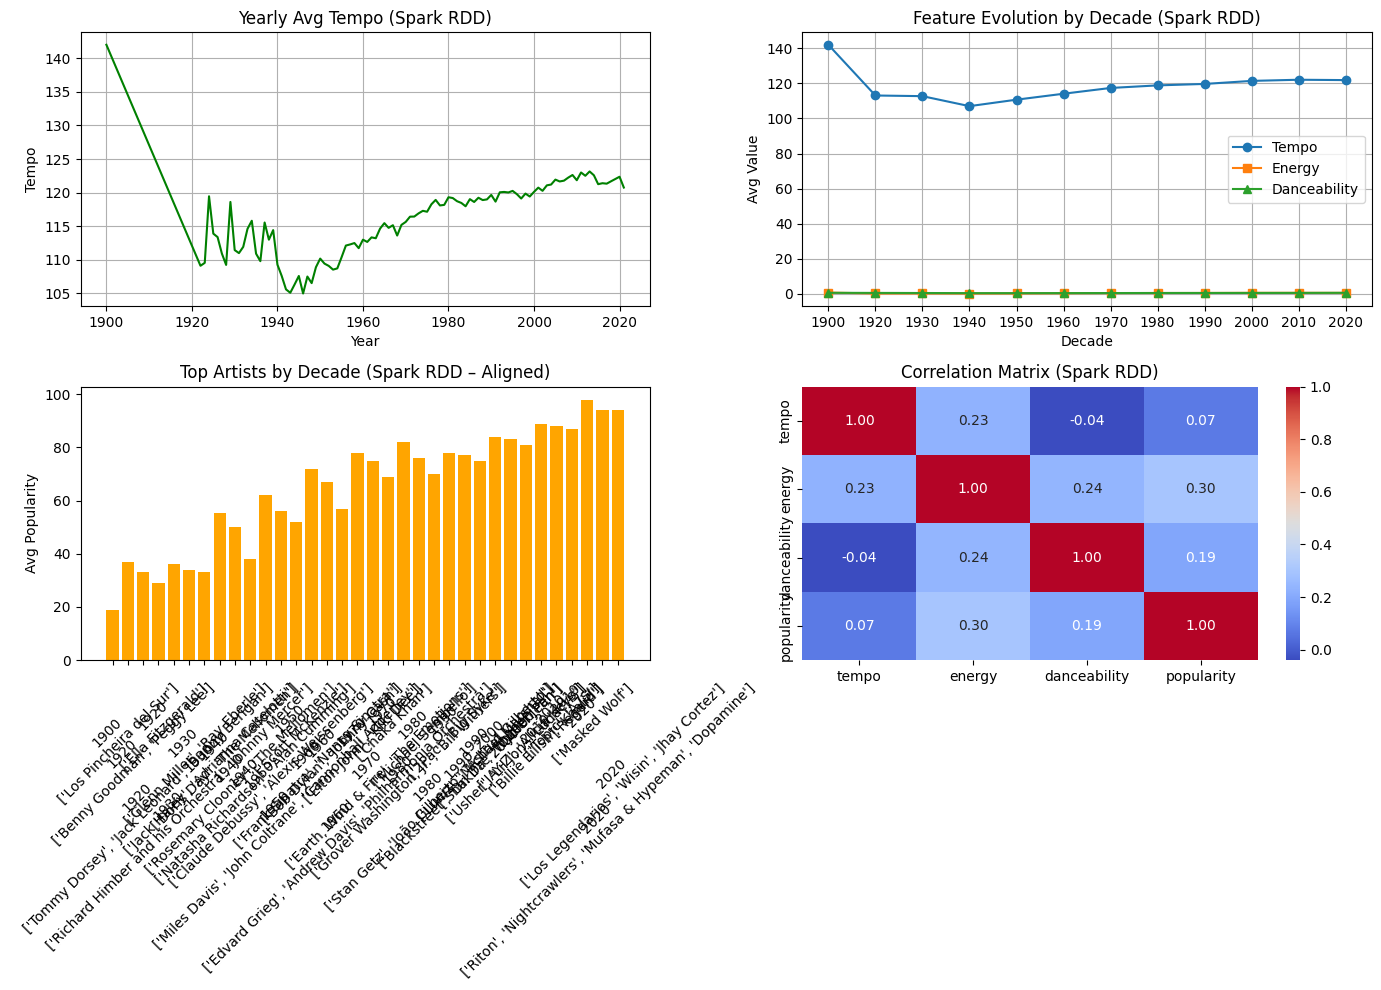

In [ ]:
from collections import defaultdict

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Graph 1 – Yearly Avg Tempo
tempo_year_spark = tempo_by_year.collect()
tempo_year_spark.sort(key=lambda x: int(x[0]))
years = [int(x[0]) for x in tempo_year_spark]
tempos = [x[1] for x in tempo_year_spark]

axs[0, 0].plot(years, tempos, color='green')
axs[0, 0].set_title('Yearly Avg Tempo (Spark RDD)')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Tempo')
axs[0, 0].grid(True)

# Graph 2 – Feature Evolution by Decade
tempo_dict = tempo_decade_avg.collectAsMap()
energy_dict = energy_decade_avg.collectAsMap()
dance_dict = dance_decade_avg.collectAsMap()

decades = sorted(tempo_dict.keys(), key=lambda x: int(x))
tempo_vals = [tempo_dict[d] for d in decades]
energy_vals = [energy_dict[d] for d in decades]
dance_vals = [dance_dict[d] for d in decades]

axs[0, 1].plot(decades, tempo_vals, label='Tempo', marker='o')
axs[0, 1].plot(decades, energy_vals, label='Energy', marker='s')
axs[0, 1].plot(decades, dance_vals, label='Danceability', marker='^')
axs[0, 1].set_title('Feature Evolution by Decade (Spark RDD)')
axs[0, 1].set_xlabel('Decade')
axs[0, 1].set_ylabel('Avg Value')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Graph 3 – Top Artists by Decade (Aligned with Pandas)

# Collect (decade, artist, avg_popularity)
artist_triplets = artist_avg.map(lambda x: (x[0][0], x[0][1], x[1])).collect()

# Group by decade and sort to get top 3
decade_artist_map = defaultdict(list)
for decade, artist, pop in artist_triplets:
    decade_artist_map[decade].append((artist, pop))

final_top_artists = []
for decade in sorted(decade_artist_map.keys()):
    top3 = sorted(decade_artist_map[decade], key=lambda x: x[1], reverse=True)[:3]
    for artist, pop in top3:
        final_top_artists.append((decade, artist, pop))

# Plot
x_labels = [f"{decade}\n{artist}" for decade, artist, _ in final_top_artists]
y_vals = [pop for _, _, pop in final_top_artists]

axs[1, 0].bar(x_labels, y_vals, color='orange')
axs[1, 0].set_title('Top Artists by Decade (Spark RDD – Aligned)')
axs[1, 0].set_ylabel('Avg Popularity')
axs[1, 0].tick_params(axis='x', rotation=45)

# Graph 4 – Correlation Matrix
spark_corr_matrix = pd.DataFrame(index=['tempo', 'energy', 'danceability', 'popularity'],
                                 columns=['tempo', 'energy', 'danceability', 'popularity'])

for (f1, f2), val in corrs.items():
    spark_corr_matrix.at[f1, f2] = round(val, 2)
    spark_corr_matrix.at[f2, f1] = round(val, 2)  # symmetric

sns.heatmap(spark_corr_matrix.astype(float), annot=True, fmt=".2f", cmap='coolwarm', ax=axs[1, 1])
axs[1, 1].set_title('Correlation Matrix (Spark RDD)')

plt.tight_layout()
plt.show()
# Stop Spark
sc.stop()